(monte-carlo)=
# 蒙特卡罗方法与期权定价

## 概览

简单的概率计算可以通过以下方式完成：

* 用铅笔和纸，
* 查询关于著名概率分布的事实，
* 在我们的脑海中。

例如，我们可以轻松地计算出：

* 五次公平硬币翻转中出现三次正面的概率
* 一个随机变量的期望值，该变量以 $1/2$ 的概率等于 $-10$，以 $1/2$ 的概率等于 $100$。

但是，有些概率计算非常复杂。

经济和金融问题中经常出现复杂的概率和期望值计算。

或许处理复杂概率计算的最重要工具是[蒙特卡罗方法](https://en.wikipedia.org/wiki/Monte_Carlo_method)。

在这个讲座中，我们将介绍用于计算期望值的蒙特卡罗方法，以及在金融中的一些应用。

我们将使用以下导入。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from numpy.random import randn

FONTPATH = "fonts/SourceHanSerifSC-SemiBold.otf"
mpl.font_manager.fontManager.addfont(FONTPATH)
plt.rcParams['font.family'] = ['Source Han Serif SC']

## 蒙特卡罗简介

在本节中，我们描述如何使用蒙特卡罗计算期望值。

### 已知分布的股票价格

假设我们正在考虑购买某公司的股票。

我们的计划是：

1. 现在买入股票，持有一年后再卖出，或者
2. 用我们的钱做其他事情。

我们首先将一年后的股票价格视为一个随机变量 $S$。

在决定是否购买股票之前，我们需要知道 $S$ 分布的一些特性。

例如，假设 $S$ 的均值相对于购买股票的价格很高。

这表明我们有很好的机会以相对较高的价格卖出。

但是，假设 $S$ 的方差也很高。

这表明购买股票有风险，所以我们可能应该放弃。

无论如何，这次讨论显示了理解 $S$ 的分布的重要性。

假设，在分析数据后，我们猜测 $S$ 很好地由参数为 $\mu, \sigma$ 的对数正态分布表示。

* $S$ 与 $\exp(\mu + \sigma Z)$ 分布相同，其中 $Z$ 是标准正态。
* 我们将这个声明写为 $S \sim LN(\mu, \sigma)$。

任何关于统计的好参考资料（如 [维基百科](https://en.wikipedia.org/wiki/Log-normal_distribution)）都会告诉我们，其均值和方差为

$$
    \mathbb E S
        = \exp \left(\mu + \frac{\sigma^2}{2} \right)
$$

和

$$
    \mathop{\mathrm{Var}} S
    = [\exp(\sigma^2) - 1] \exp(2\mu + \sigma^2)
$$

到目前为止，我们还不需要使用计算机。



### 股票价格的未知分布

但现在假设我们更仔细地研究股票价格 $S$ 的分布。

我们决定股票价格取决于三个变量，$X_1$、$X_2$ 和 $X_3$（例如，销售额、通货膨胀和利率）。

具体来说，我们的研究表明：

$$
    S = (X_1 + X_2 + X_3)^p
$$

其中：

* $p$ 是一个已知的正数（即已估计），
* $X_i \sim LN(\mu_i, \sigma_i)$ 对于 $i=1,2,3$，
* 值 $\mu_i, \sigma_i$ 也是已知的，
* 随机变量 $X_1$、$X_2$ 和 $X_3$ 是相互独立的。

我们应该如何计算 $S$ 的均值？

仅用笔和纸来计算是困难的（除非比如说 $p=1$）。

但幸运的是，至少有一种简便的方法可以近似地做到这一点。

这就是蒙特卡洛方法，其运行步骤如下：

1. 在计算机上生成 $n$ 次独立抽取的 $X_1$、$X_2$ 和 $X_3$，
1. 使用这些抽取值生成 $n$ 次独立抽取的 $S$，
1. 取这些 $S$ 的抽取值的平均值。

当 $n$ 很大时，这个平均值将接近真实的平均值。

这归因于大数定律，我们在 {doc}`lln_clt` 中讨论过。

我们使用以下值为 $p$ 以及每个 $\mu_i$ 和 $\sigma_i$。

In [2]:
n = 1_000_000
p = 0.5
μ_1, μ_2, μ_3 = 0.2, 0.8, 0.4
σ_1, σ_2, σ_3 = 0.1, 0.05, 0.2

#### 使用循环的Python例程

这里是一个使用Python原生循环计算期望平均值的例程

$$
    \frac{1}{n} \sum_{i=1}^n S_i
    \approx \mathbb E S
$$

In [3]:
%%time

S = 0.0
for i in range(n):
    X_1 = np.exp(μ_1 + σ_1 * randn())
    X_2 = np.exp(μ_2 + σ_2 * randn())
    X_3 = np.exp(μ_3 + σ_3 * randn())
    S += (X_1 + X_2 + X_3)**p
S / n

CPU times: user 3.51 s, sys: 0 ns, total: 3.51 s
Wall time: 3.51 s


2.2298251350829843

我们还可以构建一个包含这些操作的函数：

In [4]:
def compute_mean(n=1_000_000):
    S = 0.0
    for i in range(n):
        X_1 = np.exp(μ_1 + σ_1 * randn())
        X_2 = np.exp(μ_2 + σ_2 * randn())
        X_3 = np.exp(μ_3 + σ_3 * randn())
        S += (X_1 + X_2 + X_3)**p
    return (S / n)

现在调用它。

In [5]:
compute_mean()

2.229779116048025

### 向量化例程

如果我们想要更准确的估计，我们应该增加 $n$。

但是上面的代码运行得相当慢。

为了让它运行得更快，让我们使用 NumPy 实现一个向量化例程。

In [6]:
def compute_mean_vectorized(n=1_000_000):
    X_1 = np.exp(μ_1 + σ_1 * randn(n))
    X_2 = np.exp(μ_2 + σ_2 * randn(n))
    X_3 = np.exp(μ_3 + σ_3 * randn(n))
    S = (X_1 + X_2 + X_3)**p
    return S.mean()

In [7]:
%%time

compute_mean_vectorized()

CPU times: user 83.4 ms, sys: 3.29 ms, total: 86.7 ms
Wall time: 86.3 ms


2.2297365458103275

请注意，这个例程运行得更快。

我们可以增加 $n$ 以提高精度，同时仍然保持合理的速度：

In [8]:
%%time

compute_mean_vectorized(n=10_000_000)

CPU times: user 793 ms, sys: 51.9 ms, total: 845 ms
Wall time: 844 ms


2.229711306480074

## 以风险中性定价欧式看涨期权

接下来，我们将在风险中性假设下对欧式看涨期权进行定价。

首先让我们讨论风险中性，然后考虑欧式期权。



### 风险中性定价

当我们使用风险中性定价时，我们根据给定资产的预期收益来决定其价格：

$$
\text{成本} = \text{预期收益}
$$

例如，假设有人承诺在抛硬币的结果为正面时支付你

- 100万美元
- 如果结果为反面，则支付0美元

我们记赔付为 $G$, 使得

$$
    \mathbb P\left\{G = 10^6 \right\} = \mathbb P\{G = 0\} = \frac{1}{2}
$$

假设此外你可以将这个承诺卖给任何希望购买的人。

- 首先他们支付给你 $P$，即你的销售价格
- 然后他们获得 $G$，可能是100万或者0。

这个资产（这个承诺）的公平价格是多少？

“公平”的定义是含糊的，但我们可以说
**风险中性价格**是50万美元。

这是因为风险中性价格仅仅是资产的预期收益，即

$$
    \mathbb E G = \frac{1}{2} \times 10^6 + \frac{1}{2} \times 0 = 5 \times 10^5
$$


### 关于风险的评论

正如名称所示，风险中性定价忽略了风险。

为了理解这一点，请考虑你是否愿意为这样一个承诺支付500,000美元。

你是更愿意肯定收到500,000美元，还是有50%的概率收到1,000,000美元，而另外50%的概率什么也不得？

至少一些读者会严格偏好第一种选择——尽管有些人可能更喜欢第二种。

思考这个问题让我们意识到500,000美元并不一定是“正确”的价格——或者，如果市场上有这样的承诺，我们会见到的价格。

尽管如此，风险中性价格是一个重要的基准，经济学家和金融市场参与者每天都试图计算它。


### 贴现

在之前的讨论中，我们忽略了时间因素。

一般来说，现在收到$x$美元比$n$个周期后（例如10年）收到$x$美元更可取。

毕竟，如果我们现在就收到$x$美元，我们可以将其存入银行中，按照利率$r > 0$计算，$n$个周期后会收到$(1 + r)^n x$。

因此，我们在考虑它们的现值时需要对未来的支付进行贴现。

我们将通过以下方式实现贴现：

* 将一期的支付乘以$\beta < 1$
* 将$n$期的支付乘以$\beta^n$等。

对于上面描述的承诺，我们的风险中性价格也需要进行同样的调整。

因此，如果$G$在$n$个周期后实现，那么风险中性价格为：

$$
    P = \beta^n \mathbb E G
      = \beta^n 5 \times 10^5
$$


### 欧式看涨期权

现在让我们来计算一个欧式看涨期权的价格。

期权由三个要素描述：

1. $n$, **到期日**，
2. $K$, **行权价**，
3. $S_n$, 在日期 $n$ 的**标的资产**价格。

例如，假设标的资产是亚马逊的一股股票。

该期权的持有者有权在 $n$ 天后以 $K$ 价格买入亚马逊的一股股票。

如果 $S_n > K$，那么持有者将会行使期权，以 $K$ 的价格买入，在 $S_n$ 的价格卖出，并且获得 $S_n - K$ 的利润。

如果 $S_n \leq K$，那么持有者将不会行使期权，收益为零。

因此，收益为 $\max\{ S_n - K, 0 \}$。

在风险中性的假设下，期权的价格是期望的折现收益：

$$ P = \beta^n \mathbb E \max\{ S_n - K, 0 \} $$

现在我们需要指定 $S_n$ 的分布，以便可以计算期望。

假设我们知道 $S_n \sim LN(\mu, \sigma)$ 且 $\mu$ 和 $\sigma$ 是已知的。

如果 $S_n^1, \ldots, S_n^M$ 是从这个对数正态分布中独立抽取的，则根据大数定律，

$$
    \mathbb E \max\{ S_n - K, 0 \}
    \approx
    \frac{1}{M} \sum_{m=1}^M \max \{S_n^m - K, 0 \}
$$

我们假设

In [9]:
μ = 1.0
σ = 0.1
K = 1
n = 10
β = 0.95

我们设置模拟次数为

In [10]:
M = 10_000_000

这是我们的代码

In [11]:
S = np.exp(μ + σ * np.random.randn(M))
return_draws = np.maximum(S - K, 0)
P = β**n * np.mean(return_draws)
print(f"蒙特卡洛期权价格约为 {P:3f}")

蒙特卡洛期权价格约为 1.036983


## 通过动态模型进行定价

在这个练习中，我们将研究一个更现实的股票价格 $S_n$ 模型。

这来自于指定股票价格的底层动力学。

首先我们指定动态。

然后我们将使用蒙特卡洛方法计算期权的价格。

### 简单动力学

一个简单的 $\{S_t\}$ 模型是

$$ \ln \frac{S_{t+1}}{S_t} = \mu + \sigma \xi_{t+1} $$

其中

* $S_0$ 是对数正态分布的，
* $\{ \xi_t \}$ 是独立同分布的标准正态分布。

在所述假设下，$S_n$ 是对数正态分布的。

为了看清楚为什么，注意到，设 $s_t := \ln S_t$，价格动力学变为

```{math}
:label: s_mc_dyms

s_{t+1} = s_t + \mu + \sigma \xi_{t+1}
```

由于 $s_0$ 是正态分布的且 $\xi_1$ 是独立同分布的正态分布，我们可以看到 $s_1$ 是
正态分布的。

继续这种方式表明 $s_n$ 是正态分布的。

因此 $S_n = \exp(s_n)$ 是对数正态的。


### 简单动态问题

我们上面研究的简单动态模型很方侈，因为我们可以计算得出$S_n$的分布。

然而，它的预测是违反事实的，因为在现实世界中，波动率（由$\sigma$衡量）并不是稳定的。

相反，它随时间而变化，有时高（如在全球金融危机期间），有时低。

根据我们上面的模型，这意味着$\sigma$不应该是常数。


### 更现实的动态模型

这使我们研究了改进的版本：

$$ \ln \frac{S_{t+1}}{S_t} = \mu + \sigma_t \xi_{t+1} $$

其中

$$
    \sigma_t = \exp(h_t),
    \quad
        h_{t+1} = \rho h_t + \nu \eta_{t+1}
$$

这里$\{\eta_t\}$也是独立同分布且标准正态的。


### 默认参数

对于动态模型，我们采取以下参数值。

In [12]:
default_μ  = 0.0001
default_ρ  = 0.1
default_ν  = 0.001
default_S0 = 10
default_h0 = 0

（这里`default_S0` 是 $S_0$ ，`default_h0` 是 $h_0$。）

对于期权，我们使用以下默认值。

In [13]:
default_K = 100
default_n = 10
default_β = 0.95

### 可视化

将 $s_t := \ln S_t$，价格动态变为

$$ s_{t+1} = s_t + \mu + \exp(h_t) \xi_{t+1} $$

以下是使用这个方程模拟路径的函数：

In [14]:
def simulate_asset_price_path(μ=default_μ, S0=default_S0, h0=default_h0, n=default_n, ρ=default_ρ, ν=default_ν):
    s = np.empty(n+1)
    s[0] = np.log(S0)

    h = h0
    for t in range(n):
        s[t+1] = s[t] + μ + np.exp(h) * randn()
        h = ρ * h + ν * randn()

    return np.exp(s)

这里我们绘制路径及其对数路径。

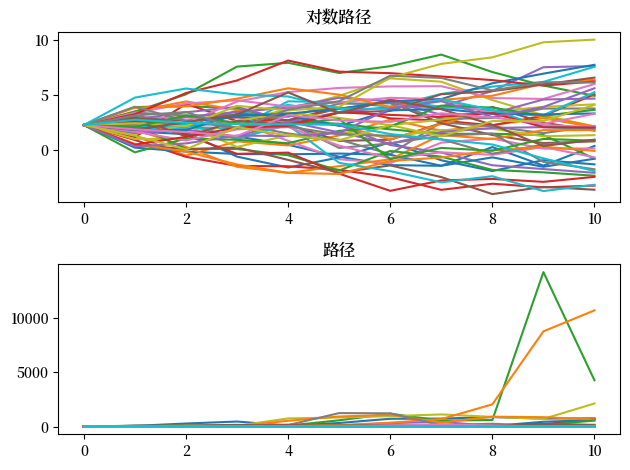

In [15]:
fig, axes = plt.subplots(2, 1)

titles = '对数路径', '路径'
transforms = np.log, lambda x: x
for ax, transform, title in zip(axes, transforms, titles):
    for i in range(50):
        path = simulate_asset_price_path()
        ax.plot(transform(path))
    ax.set_title(title)

fig.tight_layout()
plt.show()

### 计算价格

现在我们的模型更加复杂，我们无法轻易确定 $S_n$ 的分布。

所以为了计算期权的价格 $P$，我们使用蒙特卡洛方法。

我们对实现 $S_n^1, \ldots, S_n^M$ 的平均值 $S_n$，并呼吁大数法则：

$$
    \mathbb E \max\{ S_n - K, 0 \}
    \approx
    \frac{1}{M} \sum_{m=1}^M \max \{S_n^m - K, 0 \}
$$

下面是一个使用 Python 循环的版本。

In [16]:
def compute_call_price(β=default_β,
                       μ=default_μ,
                       S0=default_S0,
                       h0=default_h0,
                       K=default_K,
                       n=default_n,
                       ρ=default_ρ,
                       ν=default_ν,
                       M=10_000):
    current_sum = 0.0
    # 对每一个样本路径
    for m in range(M):
        s = np.log(S0)
        h = h0
        # 模拟时间前进
        for t in range(n):
            s = s + μ + np.exp(h) * randn()
            h = ρ * h + ν * randn()
        # 并将值 max{S_n - K, 0} 加到 current_sum
        current_sum += np.maximum(np.exp(s) - K, 0)

    return β**n * current_sum / M

In [17]:
%%time
compute_call_price()

CPU times: user 184 ms, sys: 0 ns, total: 184 ms
Wall time: 183 ms


613.4051501620951

## 练习

```{exercise}
:label: monte_carlo_ex1

我们想要在上面的代码中增加 $M$ 以使计算更加精确。

但是这存在一个问题，因为Python循环运行缓慢。

你的任务是使用NumPy编写一个更快的代码版本。
```

```{solution-start} monte_carlo_ex1
:class: dropdown
```

In [18]:
def compute_call_price_vector(β=default_β,
                       μ=default_μ,
                       S0=default_S0,
                       h0=default_h0,
                       K=default_K,
                       n=default_n,
                       ρ=default_ρ,
                       ν=default_ν,
                       M=10_000):

    s = np.full(M, np.log(S0))
    h = np.full(M, h0)
    for t in range(n):
        Z = np.random.randn(2, M)
        s = s + μ + np.exp(h) * Z[0, :]
        h = ρ * h + ν * Z[1, :]
    expectation = np.mean(np.maximum(np.exp(s) - K, 0))

    return β**n * expectation

In [19]:
%%time
compute_call_price_vector()

CPU times: user 8.2 ms, sys: 0 ns, total: 8.2 ms
Wall time: 7.78 ms


578.1310549038905

请注意，这个版本的速度比使用Python循环的版本要快。

现在让我们尝试更大的$M$以获得更准确的计算。

In [20]:
%%time
compute_call_price(M=10_000_000)

CPU times: user 3min 3s, sys: 27.6 ms, total: 3min 3s
Wall time: 3min 3s


862.0746287774725

```{solution-end}
```

```{exercise}
:label: monte_carlo_ex2

设想一种欧式看涨期权，该期权的标的资产现价为100美元，有一个120美元的敲出障碍。

这种期权在各方面都类似于普通的欧式看涨期权，但如果现价曾经超过120美元，期权便会被"敲出"，合约即刻失效。

注意，如果现价再次跌破120美元，期权不会重新激活。

使用{eq}`s_mc_dyms`定义的动态来定价这个欧式看涨期权。
```

```{solution-start} monte_carlo_ex2
:class: dropdown
```

In [21]:
default_μ  = 0.0001
default_ρ  = 0.1
default_ν  = 0.001
default_S0 = 10
default_h0 = 0
default_K = 100
default_n = 10
default_β = 0.95
default_bp = 120

In [22]:
def compute_call_price_with_barrier(β=default_β,
                                    μ=default_μ,
                                    S0=default_S0,
                                    h0=default_h0,
                                    K=default_K,
                                    n=default_n,
                                    ρ=default_ρ,
                                    ν=default_ν,
                                    bp=default_bp,
                                    M=50_000):
    current_sum = 0.0
    # 对每个样本路径进行模拟
    for m in range(M):
        s = np.log(S0)
        h = h0
        payoff = 0
        option_is_null = False
        # 模拟前向时间发展
        for t in range(n):
            s = s + μ + np.exp(h) * randn()
            h = ρ * h + ν * randn()
            if np.exp(s) > bp:
                payoff = 0
                option_is_null = True
                break

        if not option_is_null:
            payoff = np.maximum(np.exp(s) - K, 0)
        # 将payoff加入到current_sum中
        current_sum += payoff

    return β**n * current_sum / M

In [23]:
%time compute_call_price_with_barrier()

CPU times: user 1.08 s, sys: 3 μs, total: 1.08 s
Wall time: 1.08 s


0.04024473868367793

来看向量化版本，这个版本比使用Python循环快。

In [24]:
def compute_call_price_with_barrier_vector(β=default_β,
                                           μ=default_μ,
                                           S0=default_S0,
                                           h0=default_h0,
                                           K=default_K,
                                           n=default_n,
                                           ρ=default_ρ,
                                           ν=default_ν,
                                           bp=default_bp,
                                           M=50_000):
    s = np.full(M, np.log(S0))
    h = np.full(M, h0)
    option_is_null = np.full(M, False)
    for t in range(n):
        Z = np.random.randn(2, M)
        s = s + μ + np.exp(h) * Z[0, :]
        h = ρ * h + ν * Z[1, :]
        # 标记所有股价高于屏障价格的期权为无效
        option_is_null = np.where(np.exp(s) > bp, True, option_is_null)

    # 在option_is_null的索引处将payoff标记为0
    payoff = np.where(option_is_null, 0, np.maximum(np.exp(s) - K, 0))
    expectation = np.mean(payoff)
    return β**n * expectation

In [25]:
%time compute_call_price_with_barrier_vector()

CPU times: user 27.9 ms, sys: 0 ns, total: 27.9 ms
Wall time: 27.7 ms


0.034435224027807534

```{solution-end}
```